<a href="https://colab.research.google.com/github/ipejun-ai/m5-accuracy/blob/master/m5_groupkfold_0_47474.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original source of the kernel:
* https://www.kaggle.com/kyakovlev/m5-three-shades-of-dark-darker-magic
* https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv

Please give them an upvote.

I have only added GroupKFold CV. Please do give your feedback about speeding up the process or any better way for performing CV. Any feedback will be greatly appreciated. All the trained model and submission files can be found here:
* https://www.kaggle.com/ramitjaal/m5groupkfold

In [0]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
from sklearn.model_selection import GroupKFold
# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [2]:


from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
DIRPATH="/content/gdrive/My Drive/kaggle/m5-forecasting-accuracy/"
#DIRPATH="C:/Users/peiju/Documents/Study/kaggle/m5-forecasting-accuracy/"

In [0]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [0]:
########################### Helper to load data by store ID
#################################################################################
# Read data
def get_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]

    df4 = pd.read_pickle(SNAP).iloc[:,2:]
    df4 = df4[df4.index.isin(df.index)]

    #df5 = pd.read_pickle(NON_ZERO)[["moon","rolling_7_zero_count","rolling_28_zero_count"]]
    #df5 = df5[df5.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 

    df = pd.concat([df, df4], axis=1)
    del df4 # to not reach memory limit 

    #df = pd.concat([df, df5], axis=1)
    #del df5 # to not reach memory limit

    
    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

# Recombine Test set after training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test


########################### Helper to make dynamic rolling lags
#################################################################################
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [0]:
########################### Model params
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': 1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons

In [0]:
########################### Vars
#################################################################################
VER=34
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = False            # Use or not pretrained models

#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',
                   'snap_CA','snap_TX','snap_WI',
                   TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
ORIGINAL = DIRPATH
BASE     = DIRPATH+'/output/m5-simple-fe/grid_part_1.pkl'
PRICE    = DIRPATH+'/output/m5-simple-fe/grid_part_2.pkl'
CALENDAR = DIRPATH+'/output/m5-simple-fe/grid_part_3.pkl'
LAGS     = DIRPATH+'/output/m5-lags-features/lags_df_28.pkl'
MEAN_ENC = DIRPATH+'/output/m5-custom-features/mean_encoding_df.pkl'
FINAL_SALES = DIRPATH+'/output/m5-custom-features/finalsales_df.pkl'
SNAP      =  DIRPATH+'/output/m5-custom-features/snap_df.pkl'
NON_ZERO=DIRPATH+'/output/m5-custom-features/non_zero.pkl'
# AUX(pretrained) Models paths
AUX_MODELS = DIRPATH+'/output/m5-three-shades-of-dark-darker-magic/'


#STORES ids
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())
#STORES_IDS = ['CA_1'] # It takes around 5hrs to train for each store. Please run multiple kernels for each store.

#FOLDS
CV_FOLDS = [0,1,2]

#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

In [0]:
########################### Aux Models
# If you don't want to wait hours and hours
# to have result you can train each store 
# in separate kernel and then just join result.

# If we want to use pretrained models we can 
## skip training 
## (in our case do dummy training
##  to show that we are good with memory
##  and you can safely use this (all kernel) code)
if USE_AUX:
    lgb_params['n_estimators'] = 2
    
# Here is some 'logs' that can compare
#Train CA_1
#[100]	valid_0's rmse: 2.02289
#[200]	valid_0's rmse: 2.0017
#[300]	valid_0's rmse: 1.99239
#[400]	valid_0's rmse: 1.98471
#[500]	valid_0's rmse: 1.97923
#[600]	valid_0's rmse: 1.97284
#[700]	valid_0's rmse: 1.96763
#[800]	valid_0's rmse: 1.9624
#[900]	valid_0's rmse: 1.95673
#[1000]	valid_0's rmse: 1.95201
#[1100]	valid_0's rmse: 1.9476
#[1200]	valid_0's rmse: 1.9434
#[1300]	valid_0's rmse: 1.9392
#[1400]	valid_0's rmse: 1.93446

#Train CA_2
#[100]	valid_0's rmse: 1.88949
#[200]	valid_0's rmse: 1.84767
#[300]	valid_0's rmse: 1.83653
#[400]	valid_0's rmse: 1.82909
#[500]	valid_0's rmse: 1.82265
#[600]	valid_0's rmse: 1.81725
#[700]	valid_0's rmse: 1.81252
#[800]	valid_0's rmse: 1.80736
#[900]	valid_0's rmse: 1.80242
#[1000]	valid_0's rmse: 1.79821
#[1100]	valid_0's rmse: 1.794
#[1200]	valid_0's rmse: 1.78973
#[1300]	valid_0's rmse: 1.78552
#[1400]	valid_0's rmse: 1.78158

In [9]:
grid_df, features_columns = get_data_by_store("CA_1")

KeyboardInterrupt: ignored

In [0]:
def remove_zero(df):
  df["is_zero"] = np.where(df["sales"] == 0,1,0)
  tmp= df.groupby(['id'])["is_zero"].rolling(7).sum().fillna(0).reset_index()
  tmp.index=list(tmp["level_1"])
  tmp=tmp.sort_index()
  tmp=tmp.rename({"is_zero":"rolling"},axis=1)
  df=pd.concat([df,tmp],axis=1)
  ind=df["rolling"]<7
  return ind

In [11]:
########################### Train Models
#################################################################################
for store_id in STORES_IDS:
#for store_id in ["CA_1"]:
    print('Train', store_id)
    
    # Get grid for current store
    grid_df, features_columns = get_data_by_store(store_id)
    #grid_df["sales"]=grid_df["sales"]*grid_df["sell_price"]
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    ## Initiating our GroupKFold
    folds = GroupKFold(n_splits=3)

    # get subgroups for each week, year pair
    grid_df['groups'] = grid_df['tm_w'].astype(str) + '_' + grid_df['tm_y'].astype(str)
    split_groups = grid_df[train_mask]['groups']

    # Main Data
    X,y = grid_df[train_mask][features_columns], grid_df[train_mask][TARGET]
  

    for n_spilit in range(1,4):
        print('Fold:',n_spilit)
        print(END_TRAIN-P_HORIZON*n_spilit,"~", END_TRAIN-P_HORIZON*(n_spilit-1))
        #print(len(trn_idx),len(val_idx))
        
        train_mask = grid_df['d']<=(END_TRAIN-P_HORIZON*n_spilit)
        valid_mask=  (grid_df['d']>(END_TRAIN-P_HORIZON*n_spilit))& (grid_df['d']<=(END_TRAIN-P_HORIZON*(n_spilit-1)))

        zero_mask=remove_zero(grid_df)
        train_data = lgb.Dataset(grid_df[train_mask&zero_mask][features_columns], 
                       label=grid_df[train_mask&zero_mask][TARGET])
        valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                       label=grid_df[valid_mask][TARGET])  
        
        seed_everything(SEED)
        estimator = lgb.train(
                lgb_params,
                train_data,
                valid_sets = [train_data, valid_data],
                verbose_eval = 100
            )
        # Save model - it's not real '.bin' but a pickle file
        # estimator = lgb.Booster(model_file='model.txt')
        # can only predict with the best iteration (or the saving iteration)
        # pickle.dump gives us more flexibility
        # like estimator.predict(TEST, num_iteration=100)
        # num_iteration - number of iteration want to predict with, 
        # NULL or <= 0 means use best iteration
        model_name = AUX_MODELS+'lgb_model_'+store_id+'_'+str(n_spilit)+'_'+str(VER)+'.bin'
        if USE_AUX==False:
          pickle.dump(estimator, open(model_name, 'wb'))

        # Remove temporary files and objects 
        # to free some hdd space and ram memory
        train_data, valid_data, estimator
        gc.collect()

    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    grid_df = grid_df[preds_mask].reset_index(drop=True)
    keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
    grid_df = grid_df[keep_cols]
    grid_df.to_pickle('test_'+store_id+'.pkl')
    del grid_df

    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns

Train CA_1
Fold: 1
1885 ~ 1913
[100]	training's rmse: 2.87719	valid_1's rmse: 2.1785
[200]	training's rmse: 2.77029	valid_1's rmse: 2.21238
[300]	training's rmse: 2.73341	valid_1's rmse: 2.21775
[400]	training's rmse: 2.70996	valid_1's rmse: 2.21485
[500]	training's rmse: 2.69214	valid_1's rmse: 2.21369
[600]	training's rmse: 2.67758	valid_1's rmse: 2.21406
[700]	training's rmse: 2.66291	valid_1's rmse: 2.21498
[800]	training's rmse: 2.65058	valid_1's rmse: 2.21569
[900]	training's rmse: 2.63883	valid_1's rmse: 2.21605
[1000]	training's rmse: 2.62763	valid_1's rmse: 2.21438
[1100]	training's rmse: 2.61783	valid_1's rmse: 2.21519
[1200]	training's rmse: 2.60891	valid_1's rmse: 2.21735
[1300]	training's rmse: 2.59875	valid_1's rmse: 2.21861
[1400]	training's rmse: 2.59032	valid_1's rmse: 2.21968
Fold: 2
1857 ~ 1885
[100]	training's rmse: 2.89132	valid_1's rmse: 2.14348
[200]	training's rmse: 2.78122	valid_1's rmse: 2.16693
[300]	training's rmse: 2.74535	valid_1's rmse: 2.16862
[400]	trai

In [12]:
lgb_params

{'boost_from_average': False,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.5,
 'learning_rate': 0.03,
 'max_bin': 100,
 'metric': 'rmse',
 'min_data_in_leaf': 4095,
 'n_estimators': 1400,
 'num_leaves': 2047,
 'objective': 'tweedie',
 'seed': 42,
 'subsample': 0.5,
 'subsample_freq': 1,
 'tweedie_variance_power': 1.1,
 'verbose': 1}

# Evaluation


In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn import preprocessing
import lightgbm as lgb

from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

In [0]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [15]:
########################### Predict
#################################################################################

for fold_ in range(1,4):
    print("FOLD:", fold_)
    # Join back the Test dataset with 
    # a small part of the training data 
    # to make recursive features
    all_preds = pd.DataFrame()
    base_test = get_base_test()
    # Timer to measure predictions time 
    main_time = time.time()

    # Loop over each prediction day
    # As rolling lags are the most timeconsuming
    # we will calculate it for whole day
    for PREDICT_DAY in range(1,29):    
        print('Predict | Day:', PREDICT_DAY, (END_TRAIN+PREDICT_DAY-28))
        start_time = time.time()

        # Make temporary grid to calculate rolling lags
        grid_df = base_test.copy()
        grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)

        for store_id in STORES_IDS:
        
            # Read all our models and make predictions
            # for each day/store pairs
            model_path =  AUX_MODELS + 'lgb_model_'+store_id+'_'+str(fold_)+'_'+str(VER)+'.bin' 
            if USE_AUX:
                model_path =  model_path

            estimator = pickle.load(open(model_path, 'rb'))

            day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY-28)
            store_mask = base_test['store_id']==store_id

            mask = (day_mask)&(store_mask)
            base_test[TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])
            #base_test[TARGET][mask]=base_test[TARGET][mask]/base_test["sell_price"][mask]

        # Make good column naming and add 
        # to all_preds DataFrame
        temp_df = base_test[day_mask][['id',TARGET]]
        temp_df.columns = ['id','F'+str(PREDICT_DAY)]
        if 'id' in list(all_preds):
            all_preds = all_preds.merge(temp_df, on=['id'], how='left')
        else:
            all_preds = temp_df.copy()
        all_preds = all_preds.reset_index(drop=True)
        print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                      ' %0.2f min total |' % ((time.time() - main_time) / 60),
                      ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    all_preds.to_csv('all_preds_valid_'+str(fold_)+'.csv',index=False)
    del temp_df, all_preds

FOLD: 1
Predict | Day: 1 1886
##########  0.82 min round |  0.82 min total |  45837.23 day sales |
Predict | Day: 2 1887
##########  0.66 min round |  1.49 min total |  37048.33 day sales |
Predict | Day: 3 1888
##########  0.65 min round |  2.13 min total |  37646.47 day sales |
Predict | Day: 4 1889
##########  0.66 min round |  2.80 min total |  40707.78 day sales |
Predict | Day: 5 1890
##########  0.64 min round |  3.44 min total |  49663.59 day sales |
Predict | Day: 6 1891
##########  0.66 min round |  4.10 min total |  59167.12 day sales |
Predict | Day: 7 1892
##########  0.65 min round |  4.75 min total |  61002.93 day sales |
Predict | Day: 8 1893
##########  0.64 min round |  5.39 min total |  43625.22 day sales |
Predict | Day: 9 1894
##########  0.66 min round |  6.05 min total |  42671.89 day sales |
Predict | Day: 10 1895
##########  0.65 min round |  6.70 min total |  42306.24 day sales |
Predict | Day: 11 1896
##########  0.65 min round |  7.35 min total |  41205.41 d

In [0]:
all_preds_0=pd.read_csv('all_preds_valid_1'+'.csv')
all_preds_1=pd.read_csv('all_preds_valid_2'+'.csv')
all_preds_2=pd.read_csv('all_preds_valid_3'+'.csv')

In [17]:
# Create Dummy DataFrame to store predictions
final_all_preds = pd.DataFrame()
final_all_preds['id'] = all_preds_1['id']
for item in all_preds_1:
    if item!='id':
        final_all_preds[item]=(all_preds_0[item]*(3/3))+(all_preds_1[item]*(0.0/3))+(all_preds_2[item]*(0.0/3))
final_all_preds

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.832700,0.781971,0.778284,0.790967,0.985870,1.145428,1.051993,0.830328,0.732229,0.709795,0.749881,0.899231,1.083149,0.922976,0.735867,0.653656,0.680941,0.760476,0.863097,1.053992,1.041262,0.801142,0.755534,0.787176,0.796730,0.837734,1.096452,1.027228
1,HOBBIES_1_002_CA_1_validation,0.181868,0.181353,0.166566,0.212133,0.276377,0.375539,0.435353,0.235555,0.214739,0.232117,0.252046,0.250947,0.342865,0.427217,0.238030,0.230548,0.253641,0.260068,0.265042,0.345286,0.385237,0.236281,0.209488,0.213623,0.251306,0.278819,0.406639,0.408504
2,HOBBIES_1_003_CA_1_validation,0.310445,0.298121,0.317354,0.345834,0.407514,0.631878,0.596214,0.345294,0.333006,0.305500,0.332314,0.415089,0.565819,0.615750,0.345204,0.329957,0.331640,0.298309,0.406413,0.592731,0.587607,0.326409,0.303881,0.290233,0.301626,0.400045,0.543257,0.572690
3,HOBBIES_1_004_CA_1_validation,1.765946,1.515196,1.494740,1.740087,2.189675,2.909526,3.621588,1.913530,1.621247,1.469283,1.603490,1.910977,2.791360,3.520229,1.761222,1.567631,1.391832,1.491941,1.996774,2.832922,3.222133,1.763678,1.436002,1.413113,1.588986,2.170165,3.310861,3.502758
4,HOBBIES_1_005_CA_1_validation,0.983075,0.914643,0.961985,0.986293,1.232880,1.436428,1.376247,1.009126,0.898787,0.855216,0.909018,1.066009,1.421741,1.490293,0.982511,0.981610,0.968000,1.016876,1.138369,1.402273,1.420143,0.997463,0.979384,0.942351,1.003764,1.110759,1.324444,1.360693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,1.258795,0.325289,0.410324,0.454165,0.528673,0.751178,0.817586,0.512348,0.547834,0.506195,0.443965,0.502206,0.639487,0.669052,0.609750,0.605159,0.492191,0.572465,0.567415,0.582219,0.572680,0.436355,0.399324,0.413434,0.414970,0.436901,0.547516,0.598553
30486,FOODS_3_824_WI_3_validation,1.694125,0.460992,0.453557,0.509379,0.699785,0.830512,0.960260,0.583453,0.546647,0.632734,0.545122,0.785560,0.950002,0.885780,0.690916,0.720651,0.543748,0.672476,0.762962,0.751518,0.746031,0.579887,0.503063,0.470150,0.444800,0.466987,0.541009,0.570205
30487,FOODS_3_825_WI_3_validation,0.674918,0.608921,0.554808,0.663841,0.974139,1.568422,1.720947,1.207886,1.274851,1.284744,0.907712,1.255303,1.587776,1.152837,1.321764,1.305326,0.941706,1.136819,1.294606,1.240817,1.177641,0.832681,0.691733,0.670014,0.645566,0.738251,0.811338,0.874792
30488,FOODS_3_826_WI_3_validation,0.847913,0.814024,0.750629,0.937131,0.964153,1.488292,1.565645,1.027379,1.133167,1.180244,0.904915,1.102428,1.412172,1.277210,1.245023,1.219128,0.969248,1.096467,1.183865,1.268402,1.205693,1.048208,0.915082,0.973421,0.891399,0.982546,1.158515,1.212284


In [18]:
#reload data
d_dtypes = {}
for i in range(1914):
    d_dtypes[f'd_{i}'] = np.int32
sales = pd.read_csv(DIRPATH + 'sales_train_validation.csv',
                    dtype=d_dtypes)

# changing wide format to long format for model training
d = ['d_' + str(i) for i in range(1802,1914)]
sales_mlt = pd.melt(sales, id_vars=['item_id','dept_id','cat_id','store_id',
                                    'state_id'], value_vars=d)
sales_mlt = sales_mlt.rename(columns={'variable':'d', 'value':'sales'})

calendar = pd.read_csv(DIRPATH + 'calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})

# subsetting calender by traning period
calendar = calendar.loc[calendar.d.apply(lambda x: int(x[2:])) \
                        >= int(sales_mlt.d[0][2:]), :]

prices = pd.read_csv(DIRPATH + 'sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})

train_df = sales.iloc[:, :-28]
valid_df = sales.iloc[:, -28:]

evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, prices)

#sort
all_preds=pd.merge(train_df["id"],final_all_preds,on="id",how="left")
all_preds=all_preds.drop("id",axis=1)

WRMSSEE = evaluator.score(all_preds.values)

In [0]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

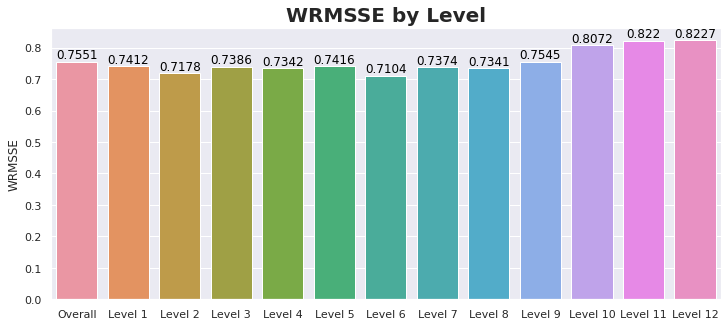

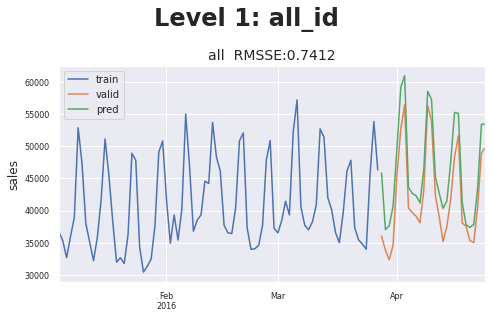

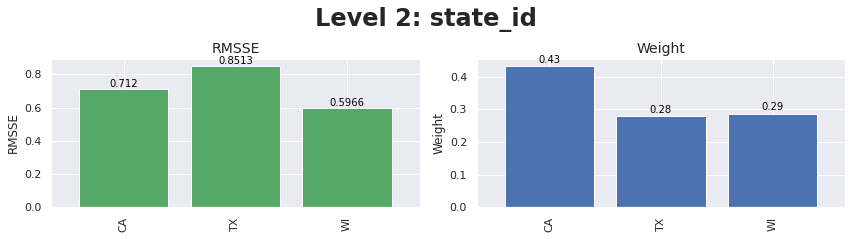

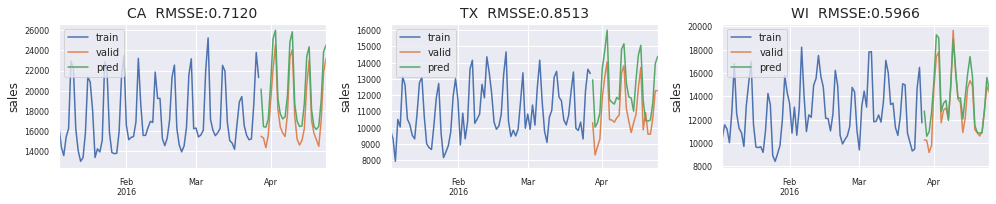

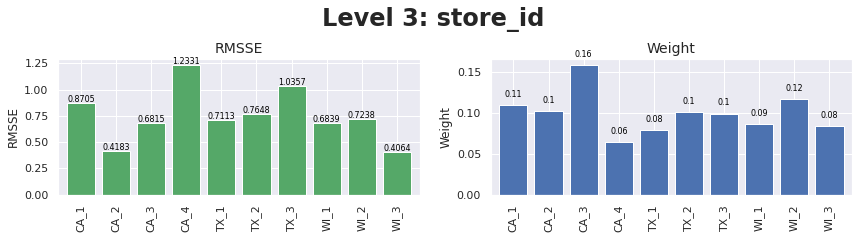

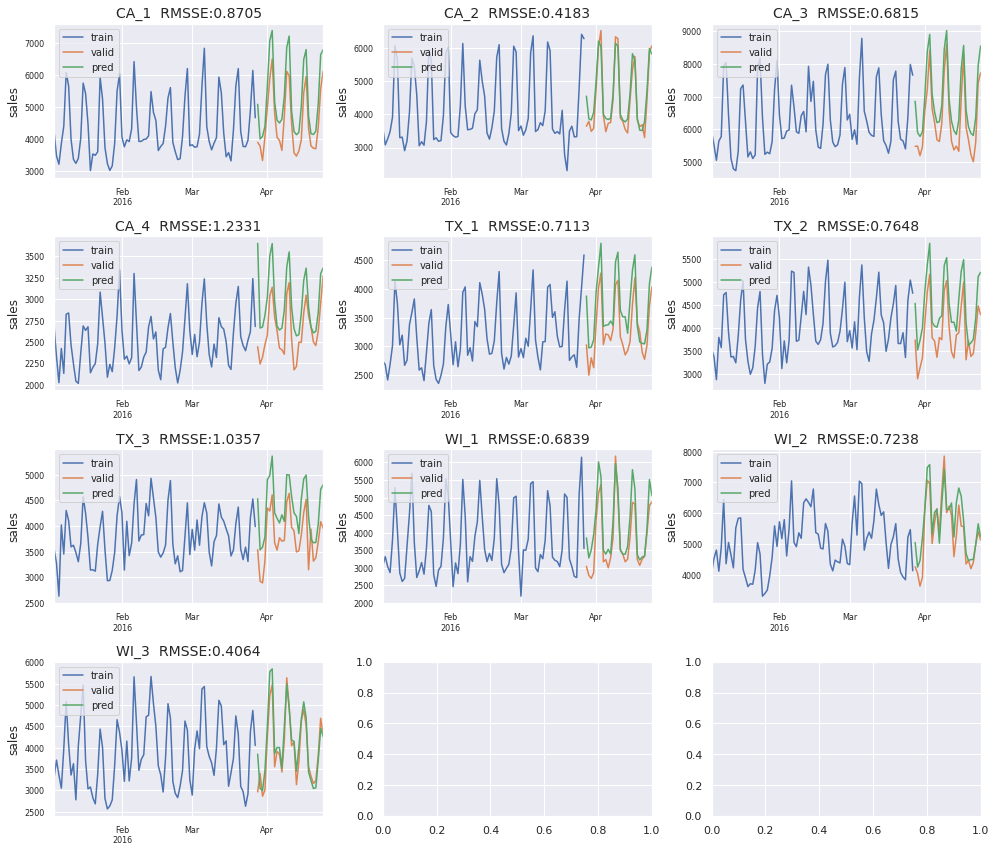

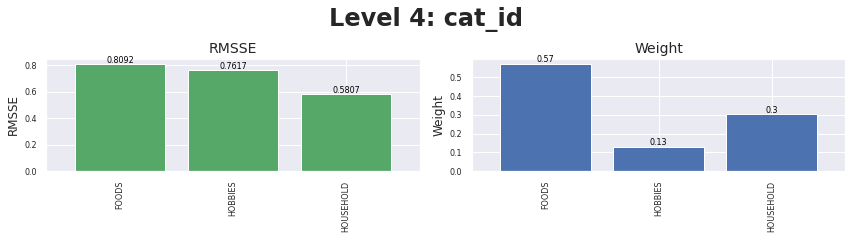

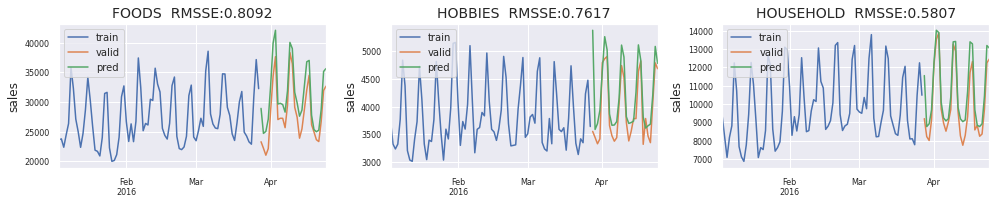

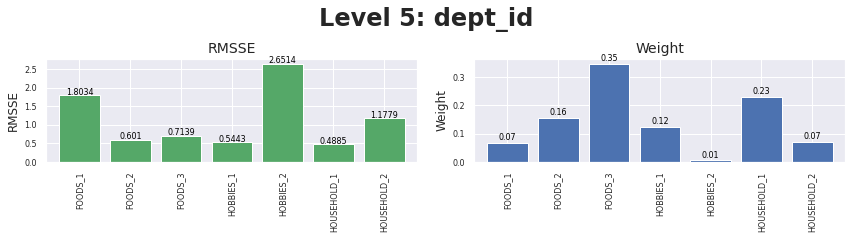

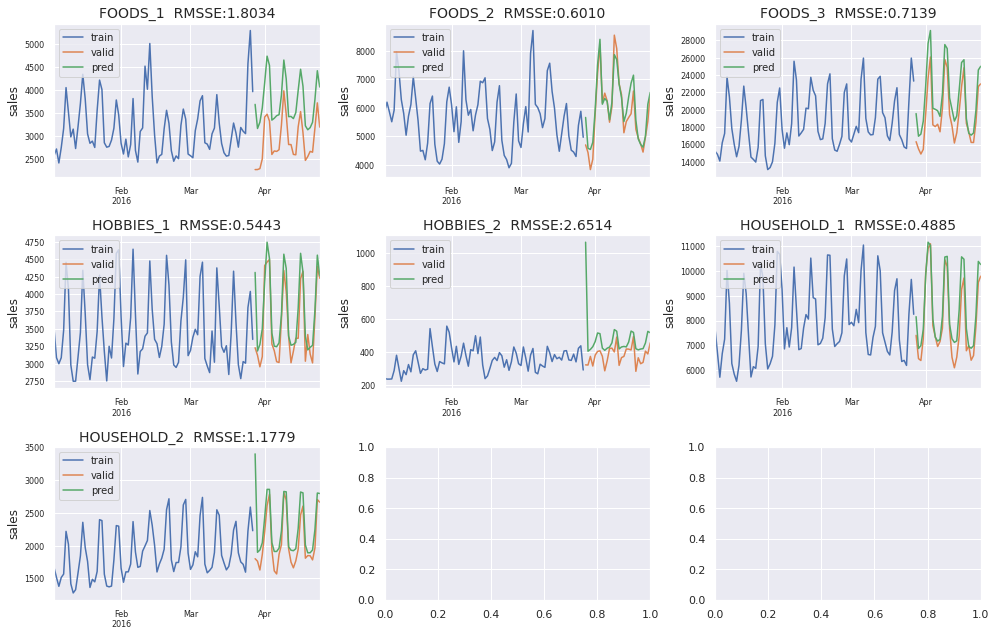

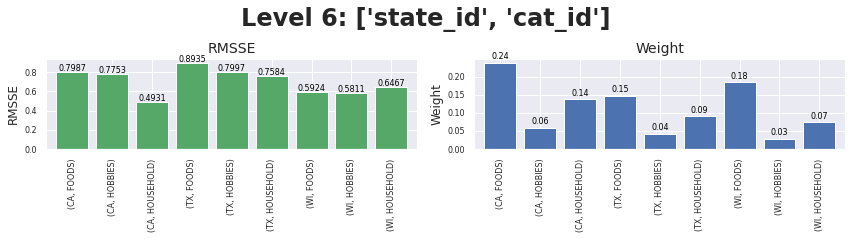

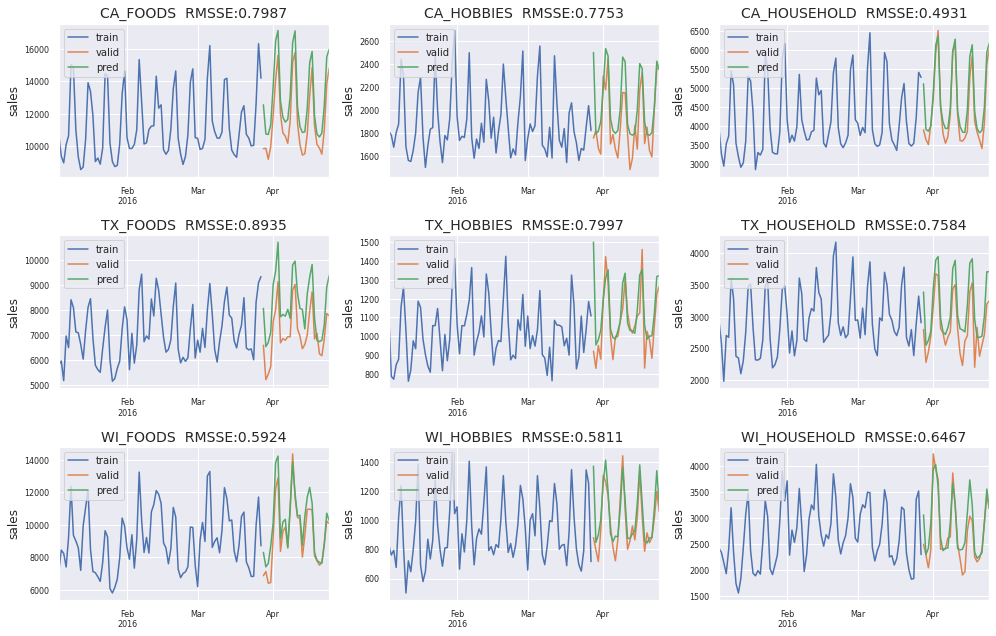

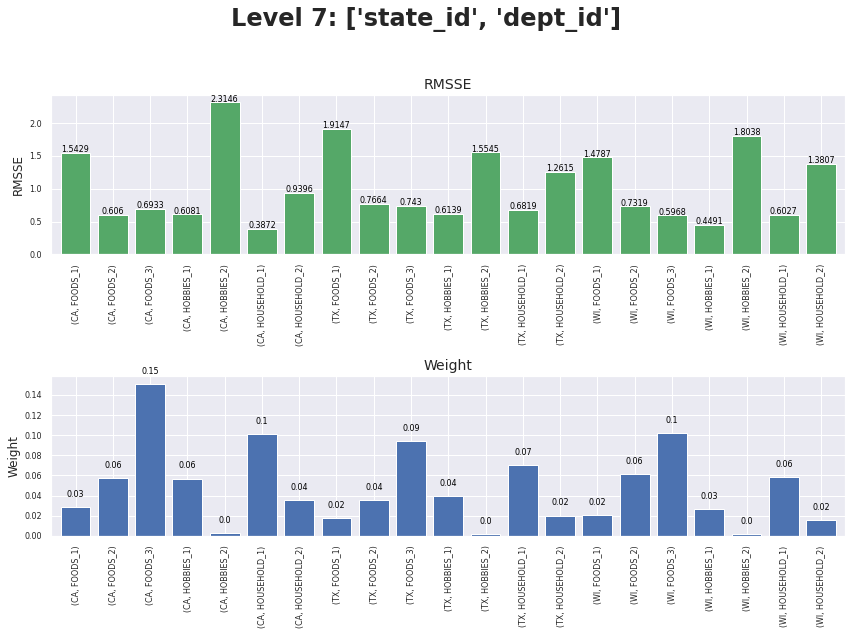

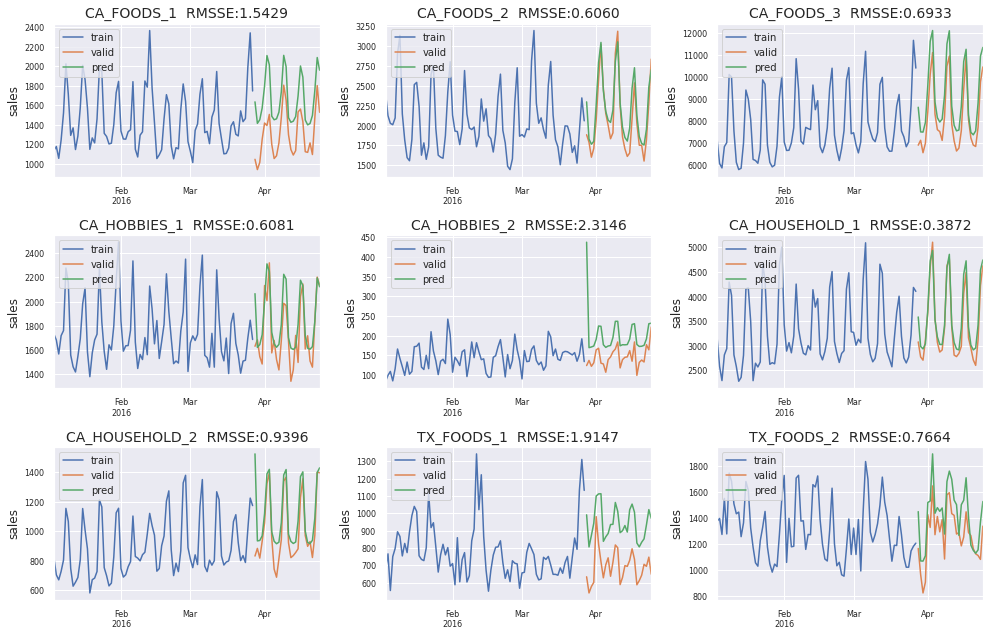

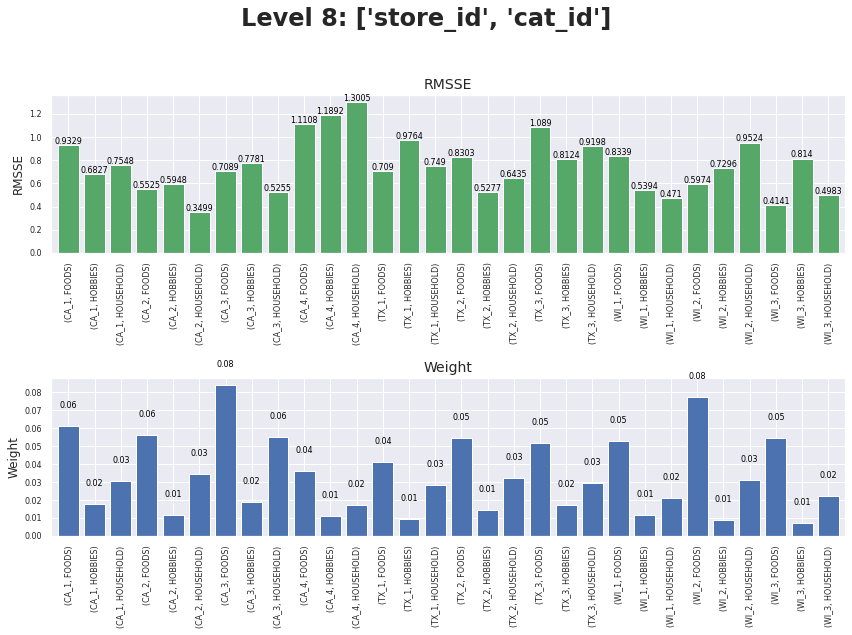

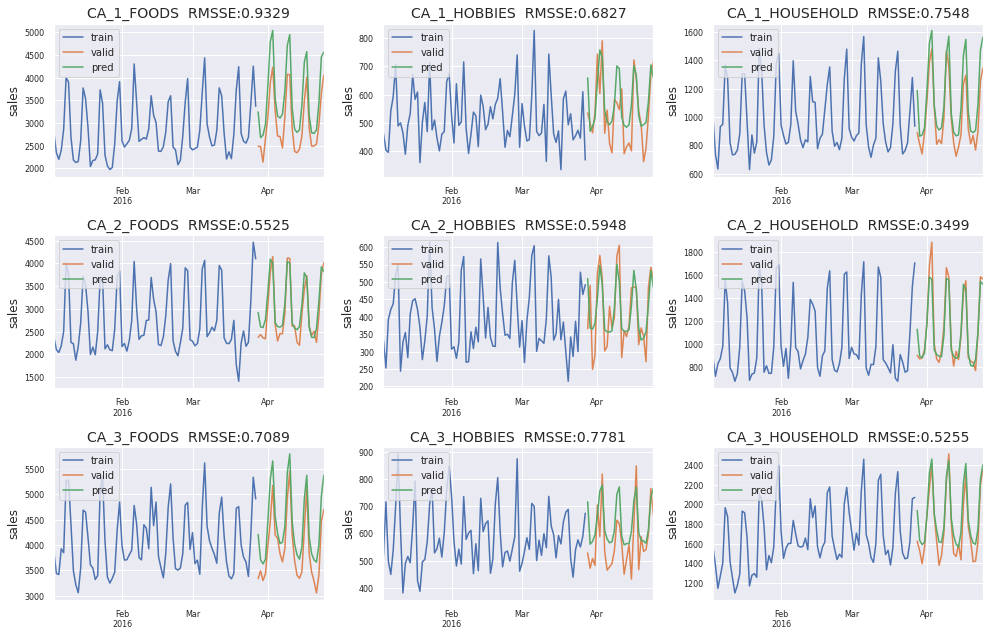

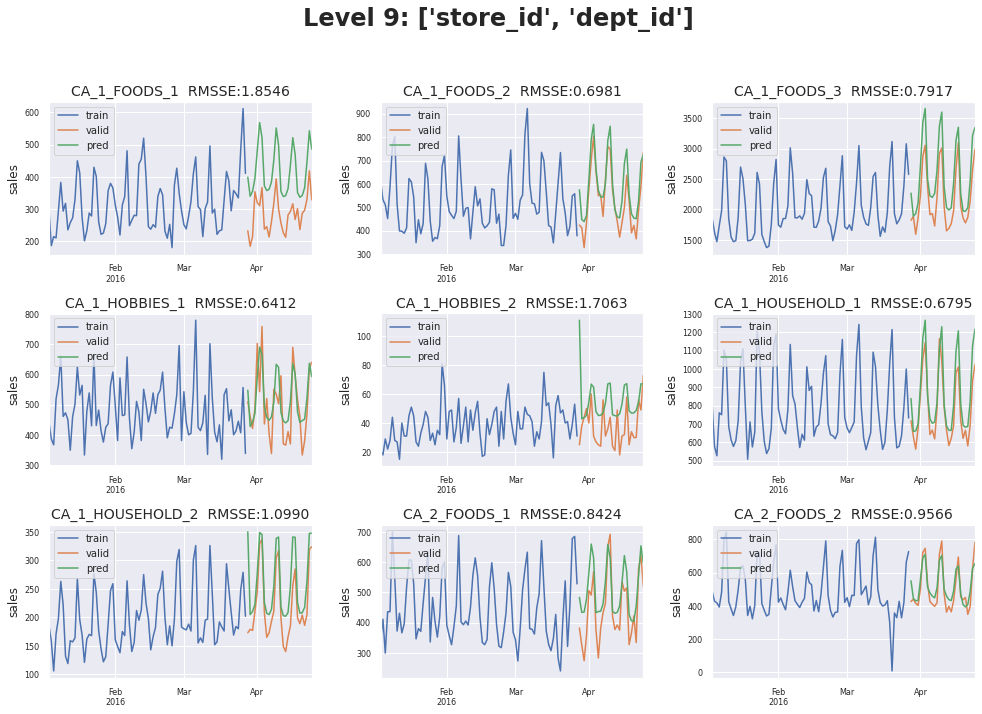

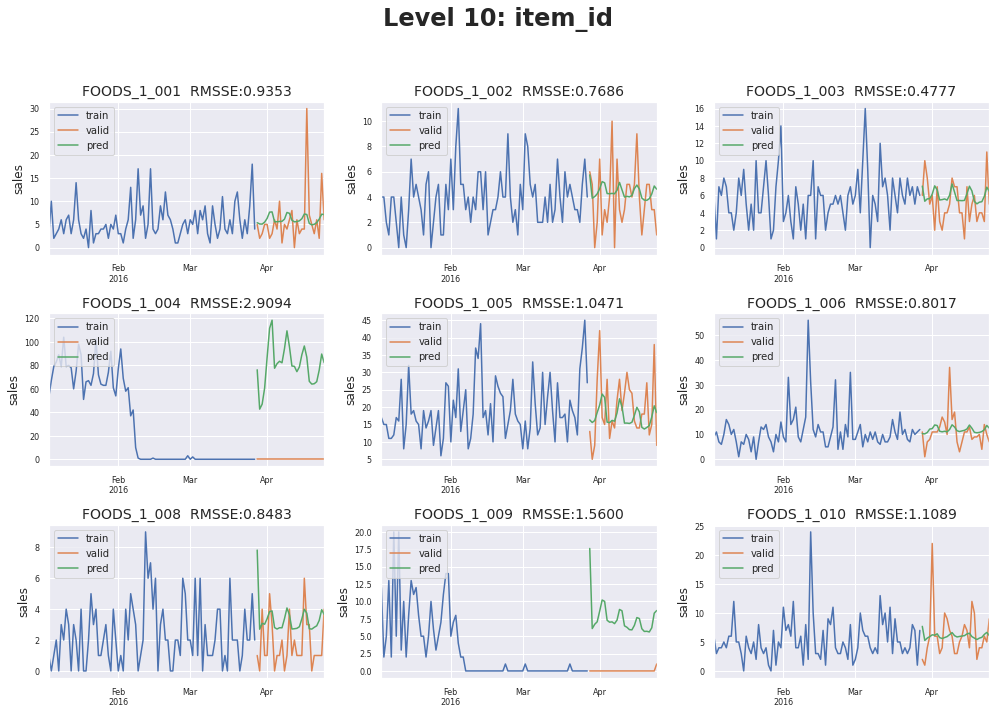

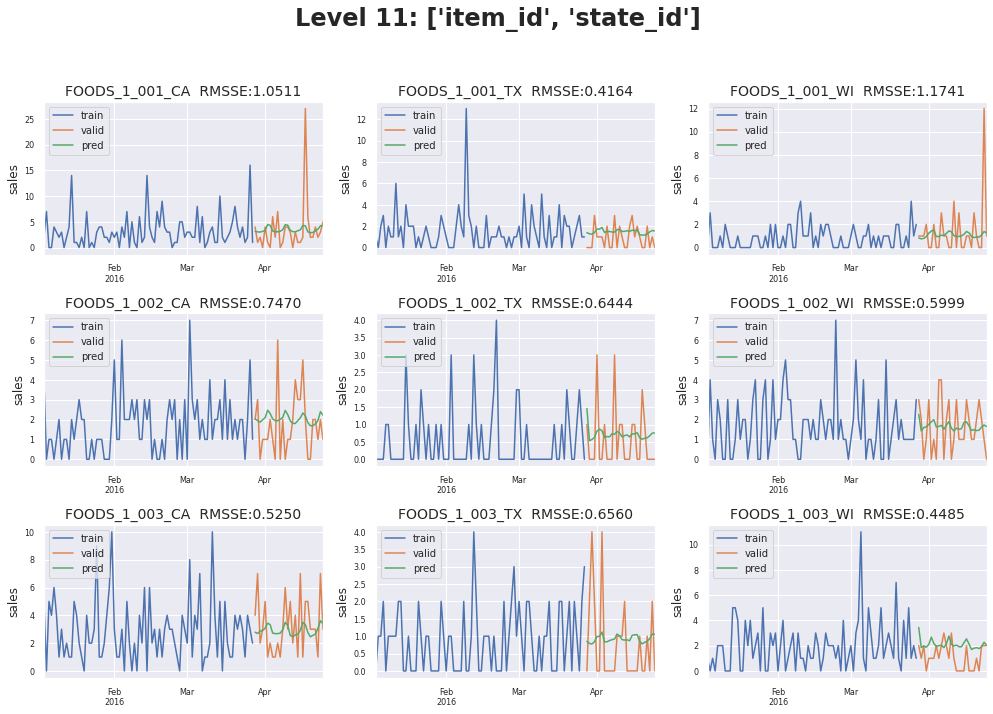

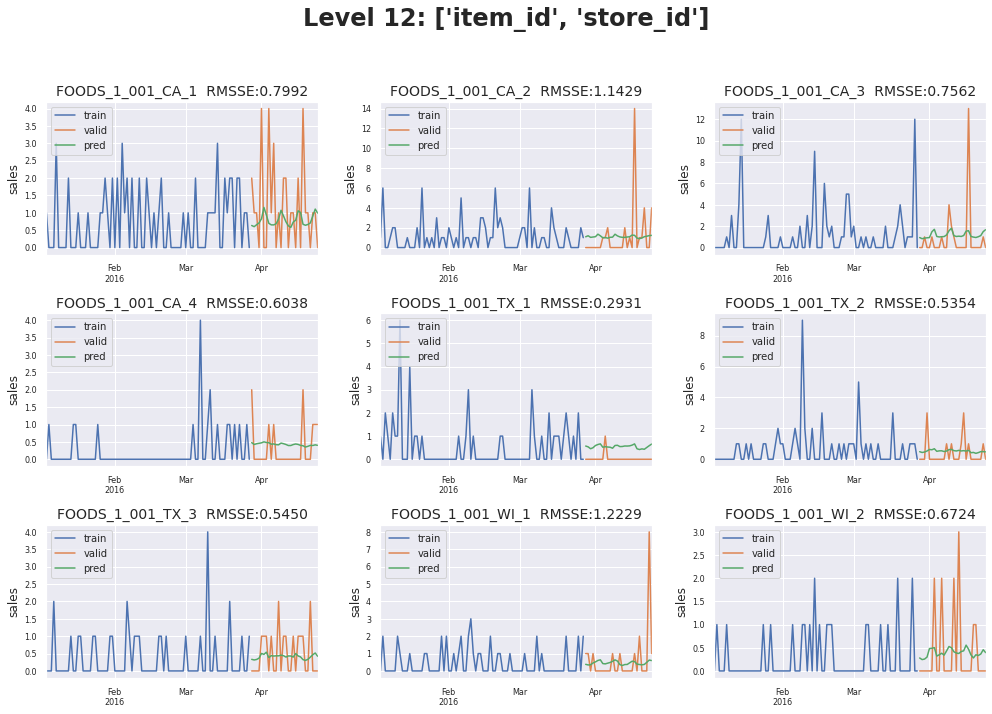

In [20]:
create_dashboard(evaluator)

In [21]:
########################### Predict
#################################################################################

for fold_ in range(1,4):
    print("FOLD:", fold_)
    # Join back the Test dataset with 
    # a small part of the training data 
    # to make recursive features
    all_preds = pd.DataFrame()
    base_test = get_base_test()
    # Timer to measure predictions time 
    main_time = time.time()

    # Loop over each prediction day
    # As rolling lags are the most timeconsuming
    # we will calculate it for whole day
    for PREDICT_DAY in range(1,29):    
        print('Predict | Day:', PREDICT_DAY)
        start_time = time.time()

        # Make temporary grid to calculate rolling lags
        grid_df = base_test.copy()
        grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)

        for store_id in STORES_IDS:
        
            # Read all our models and make predictions
            # for each day/store pairs
            model_path =  AUX_MODELS + 'lgb_model_'+store_id+'_'+str(fold_)+'_'+str(VER)+'.bin' 
            if USE_AUX:
                model_path =  model_path

            estimator = pickle.load(open(model_path, 'rb'))

            day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
            store_mask = base_test['store_id']==store_id

            mask = (day_mask)&(store_mask)
            base_test[TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])
            #base_testt[TARGET][mask]=base_test[TARGET][mask]/base_test["sell_price"][mask]

        # Make good column naming and add 
        # to all_preds DataFrame
        temp_df = base_test[day_mask][['id',TARGET]]
        temp_df.columns = ['id','F'+str(PREDICT_DAY)]
        if 'id' in list(all_preds):
            all_preds = all_preds.merge(temp_df, on=['id'], how='left')
        else:
            all_preds = temp_df.copy()
        all_preds = all_preds.reset_index(drop=True)
        print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                      ' %0.2f min total |' % ((time.time() - main_time) / 60),
                      ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    all_preds.to_csv('all_preds_'+str(fold_)+'.csv',index=False)
    del temp_df, all_preds

FOLD: 1
Predict | Day: 1
##########  0.68 min round |  0.68 min total |  45089.86 day sales |
Predict | Day: 2
##########  0.66 min round |  1.34 min total |  36487.22 day sales |
Predict | Day: 3
##########  0.65 min round |  1.99 min total |  36016.73 day sales |
Predict | Day: 4
##########  0.65 min round |  2.64 min total |  36491.87 day sales |
Predict | Day: 5
##########  0.65 min round |  3.30 min total |  43183.91 day sales |
Predict | Day: 6
##########  0.66 min round |  3.95 min total |  52728.24 day sales |
Predict | Day: 7
##########  0.67 min round |  4.62 min total |  54233.01 day sales |
Predict | Day: 8
##########  0.65 min round |  5.27 min total |  44897.41 day sales |
Predict | Day: 9
##########  0.66 min round |  5.93 min total |  45003.97 day sales |
Predict | Day: 10
##########  0.65 min round |  6.58 min total |  39547.47 day sales |
Predict | Day: 11
##########  0.65 min round |  7.23 min total |  41295.74 day sales |
Predict | Day: 12
##########  0.65 min round

In [22]:
len(MODEL_FEATURES)

70

In [0]:
all_preds_0=pd.read_csv('all_preds_1'+'.csv')
all_preds_1=pd.read_csv('all_preds_2'+'.csv')
all_preds_2=pd.read_csv('all_preds_3'+'.csv')

In [24]:
# Create Dummy DataFrame to store predictions
final_all_preds = pd.DataFrame()
final_all_preds['id'] = all_preds_1['id']
for item in all_preds_1:
    if item!='id':
        #final_all_preds[item]=(all_preds_0[item]*(1/3))+(all_preds_1[item]*(0.9/3))+(all_preds_2[item]*(0.95/3))
        final_all_preds[item]=(all_preds_0[item]*(1/3))+(all_preds_1[item]*(1/3))+(all_preds_2[item]*(1/3))
final_all_preds

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.760982,0.697388,0.689680,0.693833,0.924890,1.040365,1.038536,0.781988,0.817777,0.779464,0.706335,0.842368,0.973783,0.809407,0.788255,0.738270,0.731713,0.684406,0.776156,1.034422,0.977694,0.806941,0.737591,0.741732,0.747544,0.860551,0.965055,0.947271
1,HOBBIES_1_002_CA_1_validation,0.196765,0.197554,0.316479,0.238017,0.278493,0.317620,0.320675,0.230394,0.227387,0.217973,0.222049,0.228791,0.321019,0.285871,0.215971,0.210780,0.204826,0.212585,0.228244,0.307499,0.337332,0.225528,0.216479,0.211911,0.221431,0.246339,0.314517,0.297730
2,HOBBIES_1_003_CA_1_validation,0.393693,0.385560,0.379392,0.386084,0.496596,0.660023,0.594846,0.416174,0.402199,0.365237,0.403485,0.463771,0.613587,0.500488,0.386866,0.386458,0.375155,0.414232,0.489587,0.647852,0.654306,0.439936,0.381368,0.393947,0.399983,0.504367,0.628627,0.627322
3,HOBBIES_1_004_CA_1_validation,1.640693,1.300101,1.350117,1.488947,1.903899,3.025799,3.261602,1.647390,1.410757,1.339391,1.512065,1.662435,2.914290,2.396409,1.568351,1.468664,1.396128,1.388816,1.936478,2.603946,3.199889,1.603674,1.429872,1.376785,1.387814,1.910875,2.967584,3.421166
4,HOBBIES_1_005_CA_1_validation,0.902447,0.793630,0.855376,0.882717,1.074127,1.452926,1.541433,0.985114,0.987600,0.945165,0.923412,1.031399,1.356127,1.070888,0.971970,0.903916,0.875124,0.903795,1.025010,1.388551,1.502318,0.926061,0.825998,0.855738,0.862116,1.067439,1.497289,1.529190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.374650,0.354210,0.333775,0.338165,0.412252,0.514174,0.522803,0.523614,0.558895,0.408787,0.483392,0.524313,0.608905,0.673733,0.526907,0.455472,0.485243,0.480986,0.473048,0.626393,0.689565,0.505902,0.412084,0.400435,0.379494,0.413725,0.444950,0.517345
30486,FOODS_3_824_WI_3_validation,0.327545,0.315348,0.317676,0.305507,0.367930,0.388111,0.378266,0.404758,0.442802,0.351596,0.381178,0.418739,0.459802,0.425329,0.435191,0.338807,0.399172,0.381040,0.349785,0.491457,0.518892,0.363347,0.283707,0.277982,0.266508,0.269109,0.347720,0.360331
30487,FOODS_3_825_WI_3_validation,0.657060,0.544353,0.508030,0.517339,0.617867,0.792402,0.903882,1.060938,1.123234,0.776376,1.006691,1.089557,1.178636,1.262763,1.271993,0.816188,1.036873,1.040716,0.890698,1.301490,1.447629,1.036416,0.712651,0.678201,0.577117,0.649960,0.813064,0.855096
30488,FOODS_3_826_WI_3_validation,0.904892,0.840144,0.751580,0.742301,0.856010,1.208731,1.109126,1.196235,1.233733,0.929659,1.229126,1.188290,1.234754,1.226464,1.229097,0.979756,1.077065,1.116257,0.979471,1.358260,1.384881,0.944780,0.880620,0.816270,0.834003,0.971349,1.037458,1.141553


In [0]:
########################### Export
#################################################################################
# Reading competition sample submission and
# merging our predictions
# As we have predictions only for "_validation" data
# we need to do fillna() for "_evaluation" items
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')[['id']]
submission = submission.merge(final_all_preds, on=['id'], how='left').fillna(0)
submission.to_csv(AUX_MODELS+'submission_v'+str(VER)+'.csv', index=False)

In [0]:
# Summary

# Of course here is no magic at all.
# No "Novel" features and no brilliant ideas.
# We just carefully joined all
# our previous fe work and created a model.

# Also!
# In my opinion this strategy is a "dead end".
# Overfits a lot LB and with 1 final submission 
# you have no option to risk.


# Improvement should come from:
# Loss function
# Data representation
# Stable CV
# Good features reduction strategy
# Predictions stabilization with NN
# Trend prediction
# Real zero sales detection/classification


# Good kernels references 
## (the order is random and the list is not complete):
# https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv
# https://www.kaggle.com/jpmiller/grouping-items-by-stockout-pattern
# https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda
# https://www.kaggle.com/sibmike/m5-out-of-stock-feature
# https://www.kaggle.com/mayer79/m5-forecast-attack-of-the-data-table
# https://www.kaggle.com/yassinealouini/seq2seq
# https://www.kaggle.com/kailex/m5-forecaster-v2
# https://www.kaggle.com/aerdem4/m5-lofo-importance-on-gpu-via-rapids-xgboost


# Features were created in these kernels:
## 
# Mean encodings and PCA options
# https://www.kaggle.com/kyakovlev/m5-custom-features
##
# Lags and rolling lags
# https://www.kaggle.com/kyakovlev/m5-lags-features
##
# Base Grid and base features (calendar/price/etc)
# https://www.kaggle.com/kyakovlev/m5-simple-fe


# Personal request
# Please don't upvote any ensemble and copypaste kernels
## The worst case is ensemble without any analyse.
## The best choice - just ignore it.
## I would like to see more kernels with interesting and original approaches.
## Don't feed copypasters with upvotes.

## It doesn't mean that you should not fork and improve others kernels
## but I would like to see params and code tuning based on some CV and analyse
## and not only on LB probing.
## Small changes could be shared in comments and authors can improve their kernel.

## Feel free to criticize this kernel as my knowlege is very limited
## and I can be wrong in code and descriptions. 
## Thank you.

In [27]:
MODEL_FEATURES

['item_id',
 'dept_id',
 'cat_id',
 'release',
 'sell_price',
 'price_max',
 'price_min',
 'price_std',
 'price_mean',
 'price_norm',
 'price_nunique',
 'item_nunique',
 'price_momentum',
 'price_momentum_m',
 'price_momentum_y',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'tm_d',
 'tm_w',
 'tm_m',
 'tm_y',
 'tm_wm',
 'tm_dw',
 'tm_w_end',
 'enc_cat_id_mean',
 'enc_cat_id_std',
 'enc_dept_id_mean',
 'enc_dept_id_std',
 'enc_item_id_mean',
 'enc_item_id_std',
 'sales_lag_28',
 'sales_lag_29',
 'sales_lag_30',
 'sales_lag_31',
 'sales_lag_32',
 'sales_lag_33',
 'sales_lag_34',
 'sales_lag_35',
 'sales_lag_36',
 'sales_lag_37',
 'sales_lag_38',
 'sales_lag_39',
 'sales_lag_40',
 'sales_lag_41',
 'sales_lag_42',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_30',
 'rolling_std_30',
 'rolling_mean_60',
 'rolling_std_60',
 'rolling_mean_180',
 'rolling_std_180',
 'rolling_mean_tmp_1_7',
 'rolling_mean_tmp_1_14',
 'rolling_m

In [34]:
estimator


In [53]:
# Plot feature importance
fig, axs = plt.subplots(1, 1, figsize=[15, 4])
importances = pd.DataFrame({'features': estimator.feature_name(), 
                            'importance': estimator.feature_importance()}).sort_values('importance', ascending=False)
axs.bar(y=np.arange(len(importances)), height=importances['importance'])
axs.set_yticks(np.arange(len(importances)))
axs.set_yticklabels(importances['features'])
axs.set_xlabel('Feature importance (# times used to split)')
axs.set_title('Feature importance')

plt.show()

AttributeError: ignored

In [55]:
pd.set_option('display.max_rows', 500)
fi = estimator.feature_importance()
fi_df = pd.DataFrame({'feature': list(estimator.feature_name()),
                       'feature importance': fi[:]}).sort_values('feature importance', ascending = False)
fi_df

,feature,feature importance
0,item_id,66476
20,tm_w,23366
19,tm_d,22281
55,rolling_mean_180,18603
56,rolling_std_180,18345
54,rolling_std_60,13583
24,tm_dw,13394
57,rolling_mean_tmp_1_7,13271
11,item_nunique,12769
53,rolling_mean_60,12730
